In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler        # 평균 0,표준편차 1로 데이터 스케일링 도구 
from sklearn.model_selection import train_test_split    # 학습/(검증)/ 테스트 데이터 분할
import torch                        # Tensor 연산 및 핵심 기능
import torch.nn as nn               # 신경망 레이어 구성 및 모델 구성 모듈
import torch.nn.functional as F     # 활성화 함수/ 손실함수 등 함수
import torch.optim as optim         # 옵티마이저 (최적화 알고리즘)

In [2]:
df = pd.read_csv('./data/fetch_california_housing.csv')
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [3]:
# X, y 데이터 분리
X = df.drop('MedHouseVal',axis=1)
y = df['MedHouseVal']

In [4]:
X

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32


In [5]:
y

0        4.526
1        3.585
2        3.521
3        3.413
4        3.422
         ...  
20635    0.781
20636    0.771
20637    0.923
20638    0.847
20639    0.894
Name: MedHouseVal, Length: 20640, dtype: float64

In [6]:
# train / Test 데이터셋 분리 
X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size= 0.2,
    random_state= 42   
)


In [7]:
X_scaler = StandardScaler()

X_train_scaled = X_scaler.fit_transform(X_train)   
X_test_scaled = X_scaler.transform(X_test)   

In [8]:
# 데이터프레임 형태로 다시 만들어주기
X_train_scaled = pd.DataFrame(
       X_train_scaled,              #스케일링된 데이터(ndarray -> dataframe형태)
       columns=X_train.columns,     #기존 컬럼명 유지
       index=X_train.index          #기존 인덱스 유지
)


# 데이터프레임 형태로 다시 만들어주기
X_test_scaled = pd.DataFrame(
       X_test_scaled,              #스케일링된 데이터(ndarray -> dataframe형태)
       columns=X_test.columns,     #기존 컬럼명 유지
       index=X_test.index          #기존 인덱스 유지
)

### Linear 레이어가 2차원 출력으로 나온다 (N, out_features) - y_hat(에측값), y의 형태를 맞춰준다. 
### 이걸 맞춰주지 않으면 y_train은 (16512,) 1차원. y_hat(16512,1) 이걸 가지고 loss 계산을 할때 loss 값이 생각과 다르게 나온다 

In [9]:
# DataFrame을 pytorch 텐서로 변환해서 모델 학습 준비
X_train_tensor = torch.from_numpy(X_train_scaled.to_numpy()).float() # train 입력 데이터를 pytorch tensor (float)로 변환
X_test_tensor = torch.from_numpy(X_test_scaled.to_numpy()).float() # test 입력 데이터를 pytorch tensor (float)로 변환

y_train_tensor = torch.from_numpy(y_train.values).float().view(-1, 1) # 타깃 데이터는(샘플 수, 1) 형태로 변환
y_test_tensor = torch.from_numpy(y_test.values).float().view(-1, 1)  # 출력 차원을 맞춰주기 위한 reshape 

print(X_train_tensor.size(),X_test_tensor.size(),y_train_tensor.size(),y_test_tensor.size())


torch.Size([16512, 8]) torch.Size([4128, 8]) torch.Size([16512, 1]) torch.Size([4128, 1])


In [22]:
# 하이퍼파라미터 설정
n_epochs = 10000        # 학습 반복 횟수
learning_rate = 1e-4    # 학습률 (0.001)
print_interval = 500    # 학습 손실 출력 주기 

모델(nn.Sequential)을 사용해서 3개의 은닉층과 ReLU 활성화를 갖는 심층 회귀 모델
- 입력(X_train_tensor.size(-1s),64)  은닉 -> 은닉(64, 64) -> 은닉(64, 32) -> 출력(32, y_train_tensor.size(-1)). 

In [23]:
model = nn.Sequential(
    nn.Linear(X_train_tensor.size(1), 512),
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Dropout(0.2),

    nn.Linear(512, 256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.2),

    nn.Linear(256, 128),
    nn.ReLU(),
    nn.BatchNorm1d(128),
    nn.Dropout(0.2),

    nn.Linear(128, 64),
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.2),

    nn.Linear(64, 32),
    nn.ReLU(),

    nn.Linear(32, y_train_tensor.size(-1))
)

In [24]:
# Optimizer 설정
optimizer = optim.Adam( # Adam : 모멘텀 + RMSProp 결합한 최적화 알고리즘 
    model.parameters(), # 학습 대상이 되는 모든 가중치, 편향 파라미터
    lr = learning_rate, # 학습률
)

In [25]:
# 디바이스 설정
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

X_train = X_train_tensor.to(device)
y_train = y_train_tensor.to(device)
X_test = X_test_tensor.to(device)
y_test = y_test_tensor.to(device)

model.train() : 학습 모드
- 무조건 써야되는 상황 : 딥러닝 모델안에서 Dropout(), BatchNorm() 사용할 시 

In [26]:
# 학습 루프 
for epoch in range(n_epochs):
    model.train()                       # 학습 모드 (딥러닝 모델안에)

    y_hat = model(X_train)              # 순전파: 모델 예측값 계산 

    loss = F.mse_loss(y_hat,y_train)    # 평균 제곱 오차 손실 계산

    optimizer.zero_grad()               # 이전 step 의 기울기 초기화
    loss.backward()                     # 역전파 : 손실의 기준으로 gradient 계산
    optimizer.step()                    # 파라미터 업데이트

    # 500 epoch 마다 학습 손실 출력 
    if(epoch + 1) % print_interval == 0:
        print(f"Epoch : {epoch + 1}의 train_loss = {loss.item():.4e}")

# 테스트 손실 출력 
model.eval()      # 평가 모드 설정 (Dropout, batchnorm 비활성화)

with torch.no_grad():           # 이 안에서는 기울기 계산 비활성화
    y_perd_test = model(X_test) # 테스트 데이터로 예측
    test_loss = F.mse_loss(y_perd_test, y_test) # 테스트 손실 계산

print(f"test MSE : {test_loss.item():.4e}")

Epoch : 500의 train_loss = 4.1256e-01
Epoch : 1000의 train_loss = 3.5269e-01
Epoch : 1500의 train_loss = 3.1994e-01
Epoch : 2000의 train_loss = 2.9990e-01
Epoch : 2500의 train_loss = 2.7518e-01
Epoch : 3000의 train_loss = 2.6089e-01
Epoch : 3500의 train_loss = 2.4078e-01
Epoch : 4000의 train_loss = 2.2346e-01
Epoch : 4500의 train_loss = 2.1736e-01
Epoch : 5000의 train_loss = 2.0342e-01
Epoch : 5500의 train_loss = 1.9216e-01
Epoch : 6000의 train_loss = 1.8025e-01
Epoch : 6500의 train_loss = 1.7170e-01
Epoch : 7000의 train_loss = 1.6512e-01
Epoch : 7500의 train_loss = 1.5249e-01
Epoch : 8000의 train_loss = 1.4025e-01
Epoch : 8500의 train_loss = 1.3599e-01
Epoch : 9000의 train_loss = 1.3166e-01
Epoch : 9500의 train_loss = 1.2569e-01
Epoch : 10000의 train_loss = 1.2221e-01
test MSE : 2.4880e-01


In [ ]:
# 시각화 
model.eval()
with torch.no_grad():
   y_pred = model(X_test).to("cpu").numpy().reshape(-1) # 예측값을 mps -> Numpy반환 -> 1차원 배열로 형태 변환
   y_true = y_test.to("cpu").numpy().reshape(-1)       # 실제값을 mps -> Numpy반환 -> 1차원 배열로 형태 변환


df_result = pd.DataFrame(
    {
        "y" : y_true,
        "y_hat" : y_pred
    }
)

df_result

,y,y_hat
0,0.47700,0.391186
1,0.45800,0.721225
2,5.00001,5.467985
3,2.18600,2.673345
4,2.78000,2.591302
...,...,...
4123,2.63300,2.733475
4124,2.66800,1.641573
4125,5.00001,5.175504
4126,0.72300,0.745942


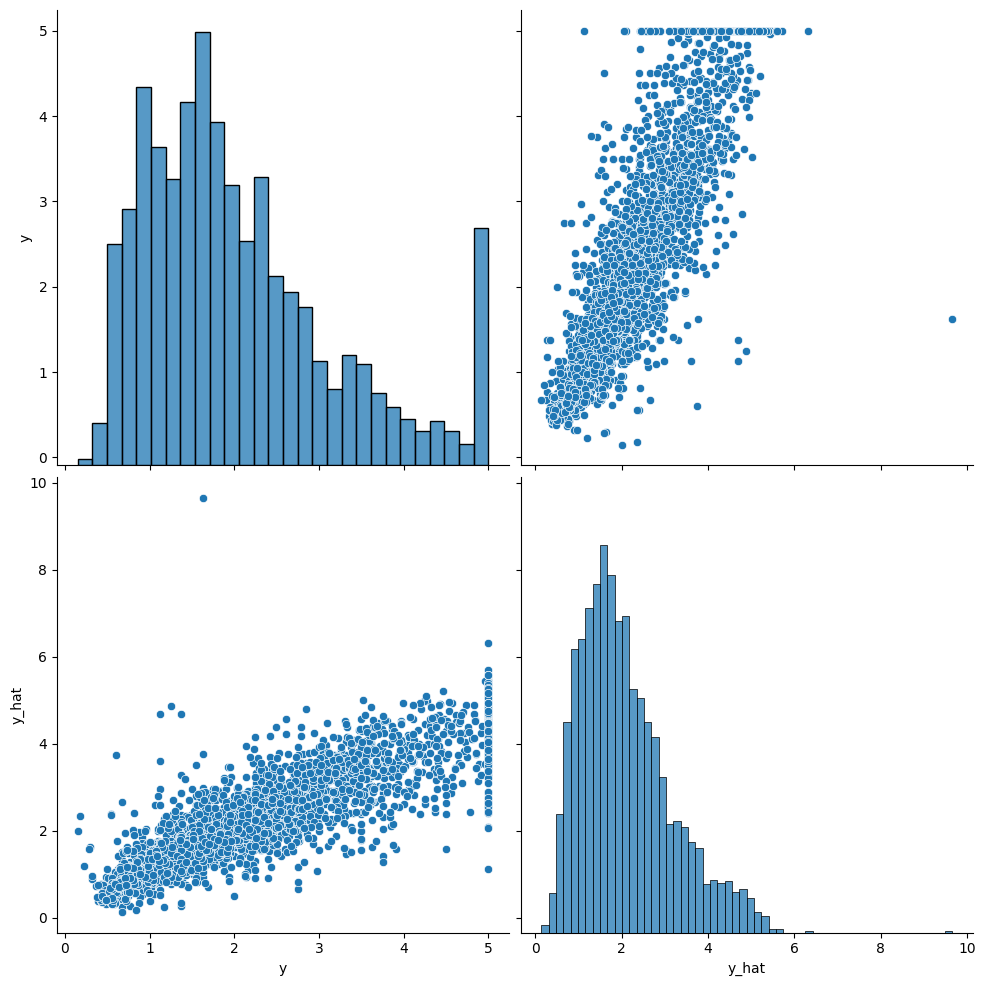

In [ ]:
sns.pairplot(df_result, height=5)
plt.show()

## 성능을 끌어올려보자 (현재 Test MSE: 2.7215e-01)
- 은닉층 줄이거나 늘려본다. (예: 64-> 32-> 16 or 200-> 150-> 100-> 50)
- (과적합시에는) Dropout or batchNorm같은것도 딥러닝 모델안에 넣어본다.
- lr별로도 비교해보기(cheduler:Ir크게 시작-> 점점 줄어드는 기법 (대표기법: ReduceLROnPlateau))
- Epochs 조절 (늘릴시 과적합 방지를 위해 early stopping도 넣어본다)
- 데이터가 많지 않으므로 머신러닝 모델도 한번 넣어본다. (예: XGBoost 등)
- 하이퍼파라미터 최적화 (Optuna)
- Adam - AdamW, NAdam, RAdam
- 손실함수 바꿔보기 (0SE)Fmseoss- (MAE)FIoss: OR (Huber)F.smooth/1_loss(옵션에 + beta=1.0)

In [ ]:
X_train_np = X_train.cpu().numpy()
y_train_np = y_train.cpu().numpy().ravel()

X_test_np = X_test.cpu().numpy()
y_test_np = y_test.cpu().numpy().ravel()

In [ ]:
from xgboost import XGBRegressor                          # XGBoost 회귀 모델
from sklearn.model_selection import GridSearchCV         # 하이퍼파라미터 탐색 도구
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # 평가 지표들

# GridSearch로 탐색할 하이퍼파라미터 조합 정의
xgb_param_grid = {
    "n_estimators": [100, 200],        # 트리 개수 (많을수록 성능↑, 학습시간↑)
    "max_depth": [None, 10, 20],       # 트리 깊이 (클수록 복잡, 과적합 위험)
    "learning_rate": [0.1, 0.01],      # 학습률 (작을수록 안정적, 느린 학습)
    "min_child_weight": [1, 2]         # 리프노드 분할 최소 가중치 (과적합 제어)
}

xgb_model = XGBRegressor(random_state=42)  # 기본 XGBoost 모델 생성 (재현성 확보)

# GridSearch 설정
xgb_grid_search = GridSearchCV(
    xgb_model,                        # 사용할 모델
    xgb_param_grid,                   # 탐색할 하이퍼파라미터 조합
    scoring="neg_mean_squared_error", # 회귀 → MSE 기준 (작을수록 좋음)
    cv=5,                             # 5겹 교차 검증
    n_jobs=-1,                        # 모든 CPU 코어 사용
    verbose=2                         # 학습 과정 출력
)

# 훈련 데이터로 최적 파라미터 탐색 시작
xgb_grid_search.fit(X_train_np, y_train_np)

# 가장 성능이 좋은 모델 선택
xgb_model = xgb_grid_search.best_estimator_

# 최적 모델로 전체 훈련 데이터 재학습
xgb_model.fit(X_train_np, y_train_np)

# 테스트 데이터 예측
y_pred = xgb_model.predict(X_test_np)

# 테스트 성능 평가
xgb_mse_test = mean_squared_error(y_test_np, y_pred)     # 평균제곱오차
xgb_mae_test = mean_absolute_error(y_test_np, y_pred)    # 평균절대오차
xgb_r2_test  = r2_score(y_test_np, y_pred)               # 결정계수 (설명력)

# 결과 출력
print("XGBoost Test MSE:", xgb_mse_test)
print("XGBoost Test MAE:", xgb_mae_test)
print("XGBoost Test R2 :", xgb_r2_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=2, n_estimators=100; total time=   0.2s
[CV] END learning_rate=0.1, max_depth=None, min_child_weight=1, n_estimators=200; total time=   0.4s
[CV] END learning_rate=0.1, m